In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from memote import ReportConfiguration
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

In [3]:
%matplotlib inline

In [4]:
colors = [
  "#A6A9AA",
  "#000000",
  "#3E7CBC",
  "#A3D2E2",
  "#DDEDF6",
  "#EDA85F",
  "#CD2028"
]

## Extract

In [5]:
bucket = []
for filename, collection in [
    ("data/bigg.csv", "bigg"),
    ("data/uminho.csv", "uminho"),
    ("data/mmodel.csv", "ebrahim"),
    ("data/agora.csv", "agora"),
    ("data/embl_gems.csv", "embl"),
    ("data/path2models.csv", "path"),
    ("data/seed.csv", "seed"),
]:
    tmp = pd.read_csv(filename)
    tmp["collection"] = collection
    bucket.append(tmp)
df = pd.concat(bucket, ignore_index=True)

In [6]:
df.shape

(1355428, 7)

In [7]:
df.head()

,test,title,section,metric,numeric,model,collection
0,test_absolute_extreme_coefficient_ratio,Ratio Min/Max Non-Zero Coefficients,matrix,0.0,NaN,iE2348C_1286,bigg
1,test_biomass_consistency,Biomass Consistency,test_biomass,0.0,0.9996577560637441,iE2348C_1286,bigg
2,test_biomass_consistency,Biomass Consistency,test_biomass,0.0,0.999994493722013,iE2348C_1286,bigg
3,test_biomass_default_production,Biomass Production In Default Medium,test_biomass,1.0,-1.717385045787279e-17,iE2348C_1286,bigg
4,test_biomass_default_production,Biomass Production In Default Medium,test_biomass,0.0,0.9824784386660113,iE2348C_1286,bigg


## Transform

### Restrict to Scored Test Cases

In [8]:
config = ReportConfiguration.load()

In [9]:
scored = set()
for name, section in config["cards"]["scored"]["sections"].items():
    scored.update(section["cases"])

In [10]:
scored_df = df[df["test"].isin(scored)].copy()

In [11]:
scored_df.shape

(223587, 7)

### Pivot Table

In [12]:
scored_df.set_index(["collection", "model", "test"], inplace=True)

In [13]:
scored_df[scored_df.index.duplicated(keep=False)].sort_index()

,,,title,section,metric,numeric
collection,model,test,,,,


In [14]:
observations = scored_df.loc[:, ["metric"]].unstack()
observations.head()

metric  \
test                                             test_biomass_specific_sbo_presence   
collection model                                                                      
agora      Abiotrophia_defectiva_ATCC_49176                                     1.0   
           Achromobacter_xylosoxidans_A8                                        1.0   
           Achromobacter_xylosoxidans_NBRC_15126                                1.0   
           Acidaminococcus_fermentans_DSM_20731                                 1.0   
           Acidaminococcus_intestini_RyC_MR95                                   1.0   

                                                                                    \
test                                             test_demand_specific_sbo_presence   
collection model                                                                     
agora      Abiotrophia_defectiva_ATCC_49176                                    1.0   
           Achromobacter_xylosoxidans_A8                                       1.0   
           Achromobacter_xylosoxidans_NBRC_15126                               1.0   
           Acidaminococcus_fermentans_DSM_20731                                1.0   
           Acidaminococcus_intestini_RyC_MR95                                  1.0   

                                                                                      \
test                                             test_exchange_specific_sbo_presence   
collection model                                                                       
agora      Abiotrophia_defectiva_ATCC_49176                                      1.0   
           Achromobacter_xylosoxidans_A8                                         1.0   
           Achromobacter_xylosoxidans_NBRC_15126                                 1.0   
           Acidaminococcus_fermentans_DSM_20731                                  1.0   
           Acidaminococcus_intestini_RyC_MR95                                    1.0   

                                                                         \
test                                             test_find_disconnected   
collection model                                                          
agora      Abiotrophia_defectiva_ATCC_49176                         0.0   
           Achromobacter_xylosoxidans_A8                            0.0   
           Achromobacter_xylosoxidans_NBRC_15126                    0.0   
           Acidaminococcus_fermentans_DSM_20731                     0.0   
           Acidaminococcus_intestini_RyC_MR95                       0.0   

                                                                                                       \
test                                             test_find_reactions_unbounded_flux_default_condition   
collection model                                                                                        
agora      Abiotrophia_defectiva_ATCC_49176                                                0.210425     
           Achromobacter_xylosoxidans_A8                                                   0.243609     
           Achromobacter_xylosoxidans_NBRC_15126                                           0.258824     
           Acidaminococcus_fermentans_DSM_20731                                            0.274823     
           Acidaminococcus_intestini_RyC_MR95                                              0.143110     

                                                                                        \
test                                             test_gene_product_annotation_presence   
collection model                                                                         
agora      Abiotrophia_defectiva_ATCC_49176                                        1.0   
           Achromobacter_xylosoxidans_A8                                           1.0   
           Achromobacter_xylosoxidans_NBRC_15126                                   1.0   
    

## Dimension Reduction

In [15]:
plt.rcParams['figure.figsize'] = 16, 9

### PCA

In [16]:
%%time
pca = PCA(n_components=2).fit_transform(observations)

CPU times: user 129 ms, sys: 241 ms, total: 370 ms
Wall time: 55 ms


In [17]:
x = []
y = []
lbl = []
for label in observations.index.get_level_values("collection").unique():
    mask = observations.index.get_level_values("collection") == label
    x.extend(pca[mask, 0])
    y.extend(pca[mask, 1])
    lbl.extend([label] * mask.sum())
pd.DataFrame({"x": x, "y": y, "collection": lbl}).to_csv("data/score_pca.csv", index=False)

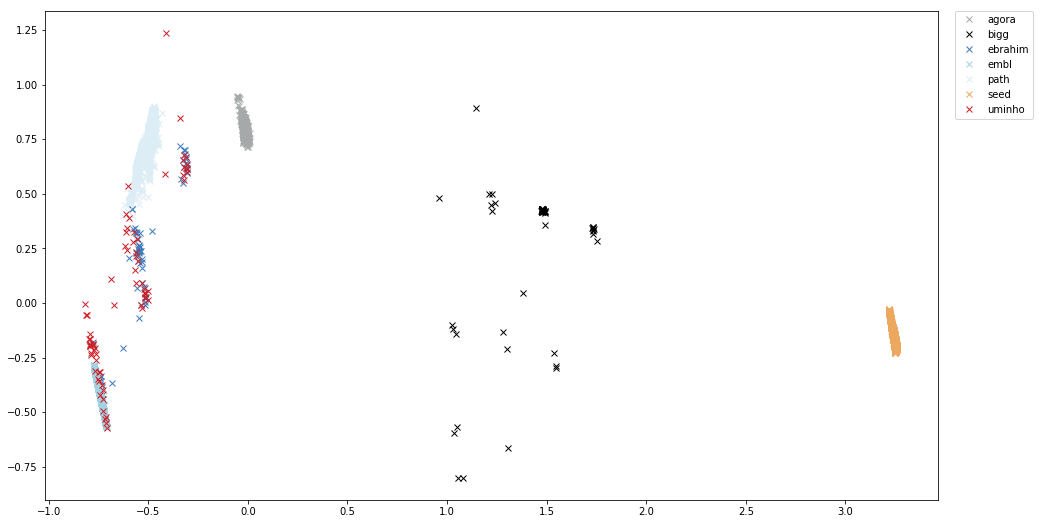

In [18]:
for label, color in zip(observations.index.get_level_values("collection").unique(), colors):
    mask = observations.index.get_level_values("collection") == label
    plt.plot(pca[mask, 0], pca[mask, 1], "x", color=color, label=label)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0)
plt.show()

### t-SNE

In [19]:
%%time
tsne = TSNE(n_components=2).fit_transform(observations)

CPU times: user 1min 6s, sys: 10.1 ms, total: 1min 6s
Wall time: 1min 6s


In [20]:
x = []
y = []
lbl = []
for label in observations.index.get_level_values("collection").unique():
    mask = observations.index.get_level_values("collection") == label
    x.extend(tsne[mask, 0])
    y.extend(tsne[mask, 1])
    lbl.extend([label] * mask.sum())
pd.DataFrame({"x": x, "y": y, "collection": lbl}).to_csv("data/score_tsne.csv", index=False)

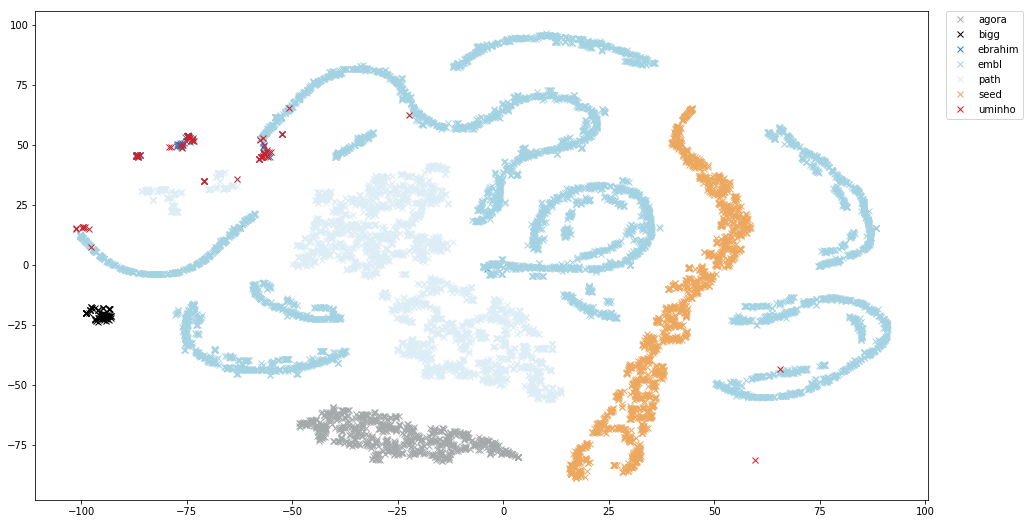

In [21]:
for label, color in zip(observations.index.get_level_values("collection").unique(), colors):
    mask = observations.index.get_level_values("collection") == label
    plt.plot(tsne[mask, 0], tsne[mask, 1], "x", color=color, label=label)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0)
plt.show()

### UMAP

In [22]:
%%time
umap = UMAP(n_components=2).fit_transform(observations)

/home/moritz/.virtualenvs/memote-meta/lib/python3.6/site-packages/umap/spectral.py:229 UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)


CPU times: user 22.8 s, sys: 7.21 s, total: 30 s
Wall time: 18.6 s


In [23]:
x = []
y = []
lbl = []
for label in observations.index.get_level_values("collection").unique():
    mask = observations.index.get_level_values("collection") == label
    x.extend(umap[mask, 0])
    y.extend(umap[mask, 1])
    lbl.extend([label] * mask.sum())
pd.DataFrame({"x": x, "y": y, "collection": lbl}).to_csv("data/score_umap.csv", index=False)

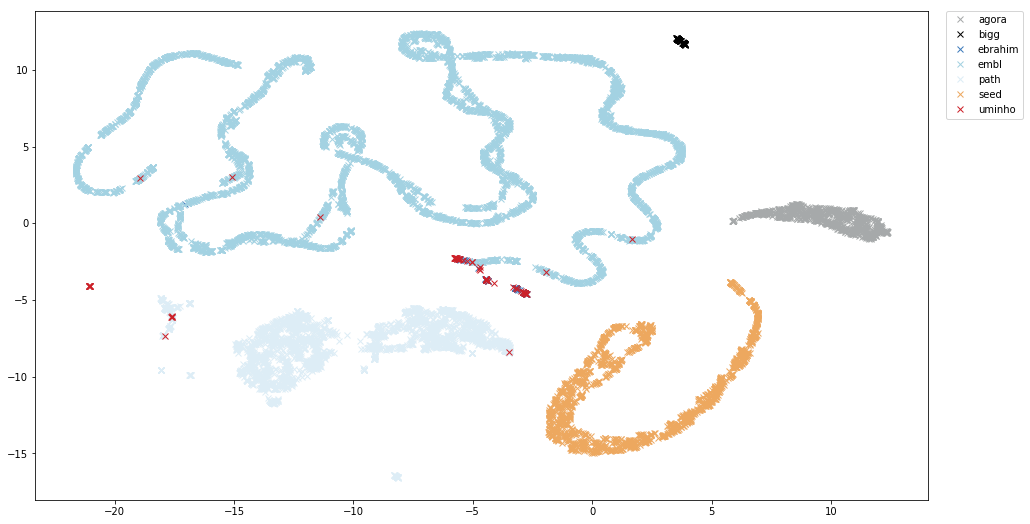

In [24]:
for label, color in zip(observations.index.get_level_values("collection").unique(), colors):
    mask = observations.index.get_level_values("collection") == label
    plt.plot(umap[mask, 0], umap[mask, 1], "x", color=color, label=label)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0)
plt.show()